This notebook contains examples related to survival analysis, based on Chapter 13 of Think Stats, 2nd Edition, by Allen Downey, available from [thinkstats2.com](http://thinkstats2.com)

In [14]:
from __future__ import print_function, division

import marriage

import thinkstats2
import thinkplot

import pandas
import numpy
from lifelines import KaplanMeierFitter
from collections import defaultdict
import itertools
import math

import matplotlib.pyplot as pyplot
from matplotlib import pylab
%matplotlib inline

The following code looks at examining the survival until marriage of women from the United States from different age brackets and cohorts.

In [2]:
resp8 = marriage.ReadFemResp2013()
resp7 = marriage.ReadFemResp2010()
resp6 = marriage.ReadFemResp2002()
resp5 = marriage.ReadFemResp1995()
resp4 = marriage.ReadFemResp1988()
resp3 = marriage.ReadFemResp1982()


resps = [resp1, resp2, resp3, resp4]

For complete cases, we know the respondent's age at first marriage.  For ongoing cases, we have the respondent's age when interviewed.

In [3]:
#For each data set, find the number of people who married and the number who have not yet
t_complete = []
t_ongoing = []
for resp in resps:
    complete = resp[resp.evrmarry == 1].agemarry
    ongoing = resp[resp.evrmarry == 0].age
    t_complete.append(complete)
    t_ongoing.append(ongoing)

There are only a few cases with unknown marriage dates.

In [4]:
t_nan = []
for complete in t_complete:
    nan = [numpy.isnan(complete)]
len(nan)

1

Here we are investigating the percent of poeple who are married compared to the total data set to make sure that there is not something weird going on with the data. From this it seems like there is definitely something going on with the 1988 data.

In [5]:
resps = [resp1, resp2, resp3, resp4, resp5]
data_set_names = [2010, 2002, 1995, 1982, 1988]

for i in range(len(resps)):
    married = resps[i].agemarry
    valued = [m for m in married if str(m) != 'nan']
    #print proportion of people who have a value for this
    print(data_set_names[i], len(valued)/len(resps[i]))

2010 0.449548008796
2002 0.534999345807
1995 0.630957868535
1982 0.604969255866
1988 0.234201183432


EstimateHazardFunction is an implementation of Kaplan-Meier estimation.

With an estimated hazard function, we can compute a survival function.

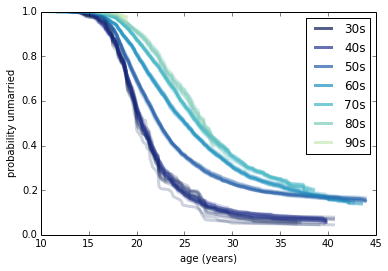

In [6]:
survival.PlotResampledByDecade(resps, weighted=True)
thinkplot.Config(xlabel='age (years)', ylabel='probability unmarried', legend=True, pos=2)

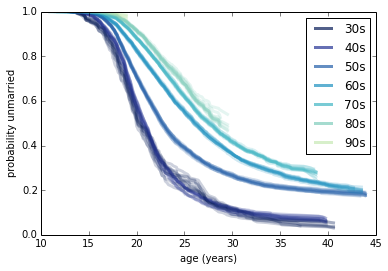

In [7]:
survival.PlotResampledByDecade(resps, weighted=False)
thinkplot.Config(xlabel='age (years)', ylabel='probability unmarried', legend=True, pos=2)

Here we use the surviavl function to look at how the percent of people marries as a function of decade and cohort. 

In [34]:
def PlotResampledByAge(resps, n=6, **options):
    """
    Takes in a list of the groups of respondents and the number of desired age brackets dsiplays a plot comparing the 
    probability a woman is married against her cohort for n number of age groups
    
    resps -- list of dataframes
    n -- number of age brackets 
    """
#     for i in range(11):
#         samples = [thinkstats2.resample_rows_weighted(resp) 
#                    for resp in resps]
    sample = pandas.concat(resps, ignore_index=True)
    groups = sample.groupby('fives')
    #number of years per group if there are n groups
    group_size = 30/n 
    
    #labels age brackets depending on # divs
    labels = ['{} to {}'.format(int(15 + group_size * i), int(15+(i+1)*group_size)) for i in range(n)] 
    # 0 representing 15-24, 1 being 25-34, and 2 being 35-44
    
    #initilize dictionary of size n, with empty lists
    prob_dict = {i: [] for i in range(n)} 
    #TODO: Look into not hardcoding this
    decades = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
    
    for _, group in groups:
        #calcualates the survival function for each decade
        _, sf = survival.EstimateSurvival(group)
        if len(sf.ts) > 1:
            #iterates through all n age groups to find the probability of marriage for that group
            for group_num in range(0,n):
                temp_prob_list = sf.Probs([t for t in sf.ts 
                                           if (15 + group_size*group_num) <= t <= (15 + (group_num+1)*group_size)])
                if len(temp_prob_list) != 0:
                    prob_dict[group_num].append(1-sum(temp_prob_list)/len(temp_prob_list))
                else:
                    pass
    
    #set up subplots
    iteration = 0
    num_plots = numpy.ceil(n/6.0)
    for key in prob_dict:
        iteration += 1
        xs = decades[0:len(prob_dict[key])]
        pyplot.subplot(num_plots, 1, numpy.ceil(iteration/6))
        thinkplot.plot(xs, prob_dict[key], label=labels[key], **options)
        #add labels/legend
        thinkplot.Config(xlabel='cohort (decade birth)', ylabel='probability married', legend=True, pos=2)
        pylab.legend(loc=1, bbox_to_anchor=(1.35, 0.75))

This function will do a similar thing to the above function, but uses the derivative of the hazard function to investigate how the hazard of marriage changes as a function of age and cohort.

In [31]:
def PlotResampledHazardByAge(resps, n=6, **options):
    """
    Takes in a list of the groups of respondents and the number of desired age brackets dsiplays a plot comparing the 
    probability a woman is married against her cohort for n number of age groups
    
    resps -- list of dataframes
    n -- number of age brackets 
    """
    
#     for i in range(20):
#         samples = [thinkstats2.resample_rows_weighted(resp) 
#                    for resp in resps]
#     print(len(resps[1]))


    sample = pandas.concat(resps, ignore_index=True)
    groups = sample.groupby('decade')
    #number of years per group if there are n groups
    group_size = 30/n 
    
    
    #labels age brackets depending on # divs
    labels = ['{} to {}'.format(int(15 + group_size * i), int(15+(i+1)*group_size)) for i in range(n)] 
    # 0 representing 15-24, 1 being 25-34, and 2 being 35-44
    
    #initilize dictionary of size n, with empty lists
    prob_dict = {i: [] for i in range(n)} 
    #TODO: Look into not hardcoding this
    decades = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
    
    for _, group in groups:
        #calcualates the survival function for each decade
        _, sf = survival.EstimateSurvival(group)
        if len(sf.ts) > 1:
            #iterates through all n age groups to find the probability of marriage for that group
            for group_num in range(0,n):
                temp_prob_list = numpy.diff(sf.Probs([t for t in sf.ts 
                                           if (15 + group_size*group_num) <= t <= (15 + (group_num+1)*group_size)]))
                if len(temp_prob_list) != 0:
                    prob_dict[group_num].append(sum(temp_prob_list)/len(temp_prob_list))
                else:
                    pass
    
    #Set up subplots
    iteration = 0
    num_plots = numpy.ceil(n/6.0)
    for key in prob_dict:
        iteration += 1
        xs = decades[0:len(prob_dict[key])]
        pyplot.subplot(num_plots, 1, numpy.ceil(iteration/6))
        thinkplot.plot(xs, prob_dict[key], label=labels[key], **options)
        #plot labels/legend
        thinkplot.Config(xlabel='cohort (decade birth)', ylabel='Hazard of Marriage', legend=True, pos=2)
        pylab.legend(loc=1, bbox_to_anchor=(1.35, 0.75))

Plotting the hazard to see trends across cohorts 

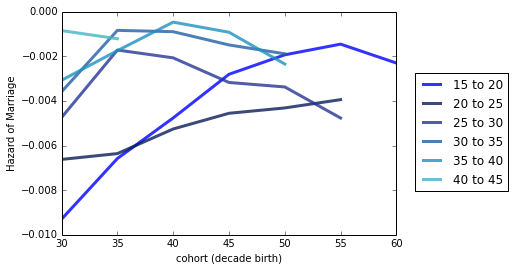

In [32]:
pyplot.hold(True)
PlotResampledHazardByAge(resps, 6)

Here we plot how the hazard of marriage changes across cohort using a finer break down of age groups. Doing this allows us to see a little more clearly the change in how people of each age group are at hazard in subsequent generations.

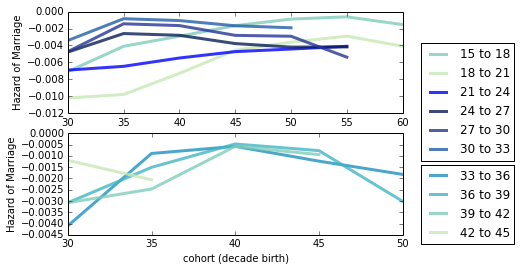

In [33]:
pyplot.hold(True)
PlotResampledHazardByAge(resps, 10)

Here we do a similar analysis looking at survival.

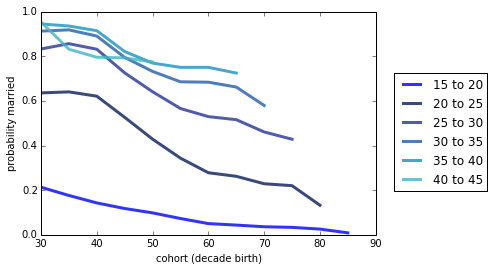

In [35]:
pyplot.hold(True)
PlotResampledByAge(resps, 6)

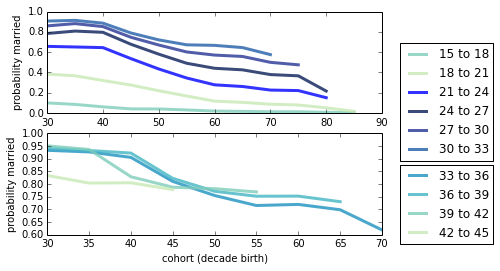

In [36]:
pyplot.hold(True)
PlotResampledByAge(resps, 10)